# Assignment Jan 2022. Wells along a river


:author: Prof. dr.ir. T.N.Olsthoorn

2021-12-22, june 2022

## Problem statement

Consider a region to the right of a straight river which is in direct contact with a water table aquifer that has a transmissivity of 900 m2/d or an average saturated thickness of 30 m and a horizontal conductivity of k=30 m/d. The specific yield of the aquifer is 10%.

There is a regional groundwater flow directed towards that river at a rate of q = 1 m2/d.

A groundwater pumping station with one well is installed at 1500 m distance from the river which starts extracting at time t=0 at a rate of 1200 m3/d. For the analysis the aquifer thickness can be considered constant as given above.

1.	Make a picture of the water table at a line through the pumping well perpendicular to the river at t the following times 0.001, 1day, 1 week, 1 month, 1 year, 10 years after the start of the extraction.
2.	Make a picture of the head contours in top view after 1 month, 1 year and 10 years.
3.	Make a picture of the flow direction in top view after 1 month, 1 year and 10years.
4.	Make a picture of the rate of inflow [m2/d] from the river after 1 month, 1 year and 10 years.
5.	At what 2 points at the river is the inflow after 1 year just zero?
6.	The river stage varies like a sine with an amplitude of 2 m and a cycle time of 1 year. How far from the river can this fluctuation be felt if one takes 10 cm amplitude as a criterion?
7.	Plot the envelopes on top of the steady state (or the head after years of constant pumping).
8.	How much is the delay of the stage wave in the river at the point where the amplitude is still only 10 cm?
9.	There is a sudden shower of rain equal to 240 mm, which raises the water table suddenly and uniformly.
10.	By how much will the water table rise due to this sudden recharge is it is assumed that all this precipitation will add to the groundwater?
11.	Show the development of the water table over time (for a few times after the shower took place) by adding its effect to the steady-state situation (pumping station has been pumping continuously for at least 10 years? 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import exp1, erfc

## Convenient plot functions

In [2]:
def newfig(title='?', xlabel='?', ylabel='?', xlim=None, ylim=None, xscale=None, yscale=None, figsize=(10, 8),
            fontsize=16):
    sizes = ['xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large']
    
    assert isinstance(fontsize, int) or fontsize in sizes, \
        "fontsize not int and not in [{}]".format(', '.join(sizes))
                
    _, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xlim: ax.set_xlim(xlim)
    if ylim: ax.set_ylim(ylim)
    if xscale: ax.set_xscale(xscale)
    if yscale: ax.set_yscale(yscale)
    ax.grid()
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)
    return ax

def newfigs(layout, titles=['?'], xlabels=['?'], ylabels=['?'], xscales=None, yscales=None,
            xlim=None, ylim=None, sharex=None, sharey=None, fontsize=16, figsize=(10, 8)):
    sizes = ['xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large']
    
    assert isinstance(fontsize, int) or fontsize in sizes, \
        "fontsize not int and not in [{}]".format(', '.join(sizes))
                
    fig, axs = plt.subplots(*layout, sharex=sharex, sharey=sharey)
    fig.set_size_inches(figsize)

    assert isinstance(layout, tuple) and len(layout) == 2, 'layout must be a 2-tuple (nrows, ncols) not {}'.format(str(layout))
    n_axes = np.prod(layout)
    
    if xscales is None: xscales = [None for _ in range(n_axes)]
    if yscales is None: yscales = [None for _ in range(n_axes)]
        
    for items_name, items in zip(['titles', 'xlabels', 'ylabels', 'xscales', 'yscales'], [titles, xlabels, ylabels, xscales, yscales]):
        assert len(items) == np.prod(layout), 'len({}) == {} != len(layout) == {}'.format(items_name, len(items), np.prod(layout))
        
    for ax, title, xlabel, ylabel, xscale, yscale in zip(axs.ravel(), titles, xlabels, ylabels, xscales, yscales):        
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if xlim: ax.set_xlim(xlim)
        if ylim: ax.set_ylim(ylim)
        if xscale: ax.set_xscale(xscale)
        if yscale: ax.set_yscale(yscale)
        ax.grid()
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize)
    return axs

## The data

In [3]:
# Aquifer
k, D, Sy  = 30, 30, 0.1 # m/d, m, (-)
kD = k * D # m2/d

L = 1500 # m, distance from well to river
Q = 1200 # m3/d, extraction from well
q = 1 # m2/d, unifrom groundwater dicharge from right to left

show_times = np.array([np.datetime64(k) for k in ['2022-01-01', '2022-01-02', '2022-01-08', '2022-02-01', '2023-01-01', '2032-01-01']])
tstart = np.datetime64('2021-12-31T23:50')

wells = {1: {'type': 'w', 'sign': +1, 'x':-L, 'y':0., 'r0': 0.25},
         2: {'type': 'm', 'sign': -1, 'x':+L, 'y':0., 'r0': 0.25},         
         }


### 1.	Make a picture of the water table at a line through the pumping well perpendicular to the river at t the following times 0.001, 1day, 1 week, 1 month, 1 year, 10 years after the start of the extraction.

We will use the show_times defined above, to show how to work with dates.

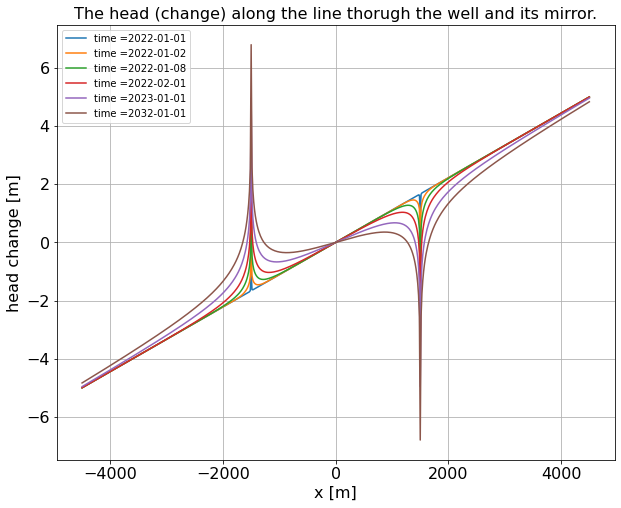

In [4]:
# The head at differnt times along the x-axis (from left to right thorugh pumping station, x=0 at river)
Np = 601
Xline = np.linspace(-3 * L, 3 * L, Np) # x coordinates
Yline = np.zeros_like(Xline)

# The head due to the reginal flow, with h=0 at x=0
h = q / kD * Xline # not the sign

ax = newfig("The head (change) along the line thorugh the well and its mirror.", "x [m]", "head change [m]")

for show_time in show_times:
    t = (show_time - tstart) / np.timedelta64(1, 'D') 

    s = h # np.zeros_line(Xline)
    
    for k in wells:
        well = wells[k]
        dx_, dy_ = Xline - well['x'], Yline - well['y']
        r2 = dx_ ** 2 + dy_ ** 2
        r2[r2 < well['r0']] = well['r0']
        u = r2 * Sy / (4 * kD * t)
        s += well['sign'] * Q / (4 *np.pi * kD) * exp1(u)     

    ax.plot(Xline, s, label=f'time ={show_time}')
    ax.legend()

### As can be seen, the difference between the situation at t=356 d and t=3650 d is very small. Hence, we can assume that the situation at t=3650 d is practically steady-state.

It is convenient and later on much more compact to set up plots more generally with a function.

### 2.	Make a picture of the head contours in top view after 1 month, 1 year and 10 years.

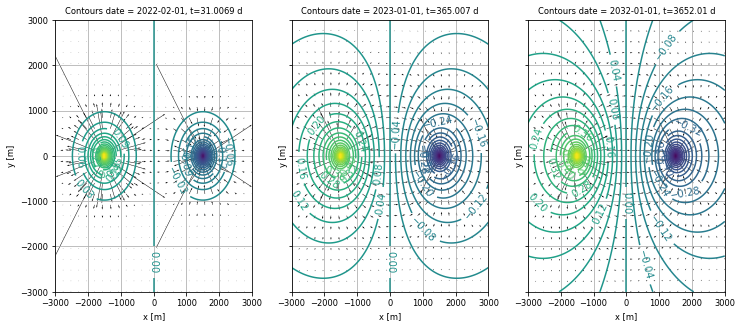

In [29]:

# Generate the 2 grids of coordinates: (using np.meshgrid)
Np = 101
# For contours
Xcline = np.linspace(- 2 * L, 2 * L, Np + 1)
Ycline = np.linspace(- 2 * L, 2 * L, Np + 1)

# For quiver
Xqline = np.linspace(- 2 * L, 2 * L, Np//4 + 1)
Yqline = np.linspace(- 2 * L, 2 * L, Np//4 + 1)

Xc, Yc = np.meshgrid(Xcline, Ycline)
Xq, Yq = np.meshgrid(Xqline, Yqline)

aday = np.timedelta64(1, 'D')
titles  = [f'Contours date = {show_time}, t={(show_time - tstart)/aday:4g} d' for show_time in show_times[-3:]]
xlabels = ['x [m]' for _ in show_times[-3:]]
ylabels = ['y [m]' for _ in show_times[-3:]]

axs = newfigs((1, 3), titles, xlabels, ylabels, sharex=True, sharey=True, figsize=(12, 5), fontsize='small')
for ax, show_time in zip(axs.ravel(), show_times[-3:]):

    qx = np.zeros_like(Xq)
    qy = np.zeros_like(Xq)
    
    s = q / kD * Xc * .0
    t = (show_time - tstart) / np.timedelta64(1, 'D')
    
    for k in wells:
        well = wells[k]
        
        dx_, dy_ = Xc - well['x'], Yc - well['y']
        r2 = dx_ ** 2 + dy_ ** 2
        r2[r2 < well['r0']] = well['r0']
        
        u = r2 * Sy  / (4 * kD * t)
        s += well['sign'] * Q / (4 * np.pi * kD) * exp1(u)
        
        dxq, dyq = Xq - well['x'], Yq - well['y']
        rq2 = dxq ** 2 + dyq ** 2
        uq = rq2 * Sy / (4 * kD * t)
        qx += well['sign'] * Q / (2 * np.pi) * np.exp(-uq) * dxq / rq2
        qy += well['sign'] * Q / (2 * np.pi) * np.exp(-uq) * dyq / rq2
                
    cs = ax.contour(Xc, Yc, s, levels = 50)
    ax.clabel(cs)
    
    ax.quiver(Xq, Yq, qx, qy)
    
plt.show()
    

### 4 Inflow from the river. 

This is in fact the same as the question above. The main difference is that we only need the y-values at x=0. Therefore our coordinates will be those along the river, i.e. a long vector of zeros for the x and regular values for the y coordinate.

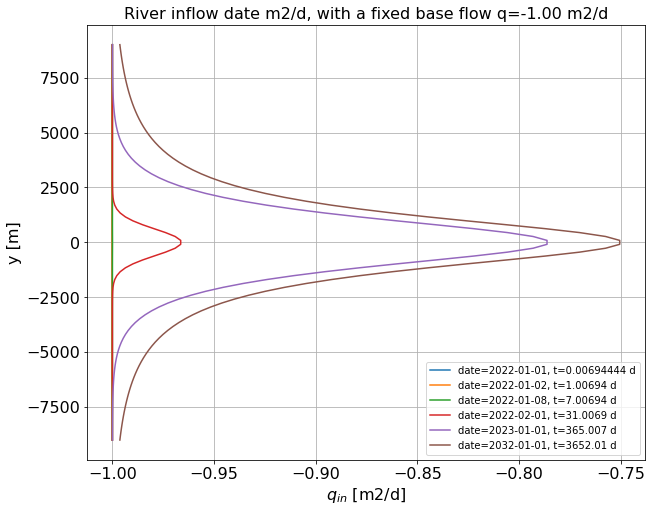

In [37]:
# Inflow at the river, i.e. X=0
q = -1 # m2/d

# Generate the 2 grids of coordinates: (using np.meshgrid)
Np = 101
# For contours
a = 6
Yriv = np.linspace(- a * L, a * L, Np + 1)
Xriv = np.zeros_like(Yriv)


ax = newfig(f'River inflow date m2/d, with a fixed base flow q={q:.2f} m2/d', '$q_{in}$ [m2/d]', 'y [m]')
for show_time in show_times:

    qx = np.zeros_like(Yriv) + q
    qy = np.zeros_like(Yriv)
    
    t = (show_time - tstart) / np.timedelta64(1, 'D')
    
    for k in wells:
        well = wells[k]
                
        dx_, dy_ = Xriv - well['x'], Yriv - well['y']
        r2 = dx_ ** 2 + dy_ ** 2
        u = r2 * Sy / (4 * kD * t)
        qx += well['sign'] * Q / (2 * np.pi) * np.exp(-u) * dx_ / r2
        qy += well['sign'] * Q / (2 * np.pi) * np.exp(-u) * dy_ / r2
                
    ax.plot(qx, Yriv, label=f'date={show_time}, t={t:3g} d')
ax.legend(loc='lower right')
plt.show()


The flow will be permanently outward, even in the steady state situation (t = 3650 d). This is due to the strong groundwater flow from the right to the left.

### Q8: Find the point where the inflow is just zero. (This may be done analytically)

There is no point at which the river infiltrates. For this to happen either the base flow should be less, or the extraction should be must higher.

### Q9: River stage varies by 2 m with T = 1 year = 365 days

In [39]:
Tcycle = 365
omega = 2 * np.pi / Tcycle
a = np.sqrt(omega * Sy / (2 * kD))

# The answer for the point at which the amplitude is reduced from 2 to 0.1 m follows from: $\frac{0.1}{2} = e^{-a x}$ 
L = np.log(2 / 0.1) / a
print("omega = {:.4g} rad/d".format(omega))
print("a     = {:.4g} /m".format(a))
print("L     = {:.4g} m".format(L))



omega = 0.01721 rad/d
a     = 0.0009779 /m
L     = 3063 m


print("The delay is {:.3g} d.".format(L * a / omega))

### Q10: plot the envelopes around the actual situation. Just use steady-state drawdown for convenience

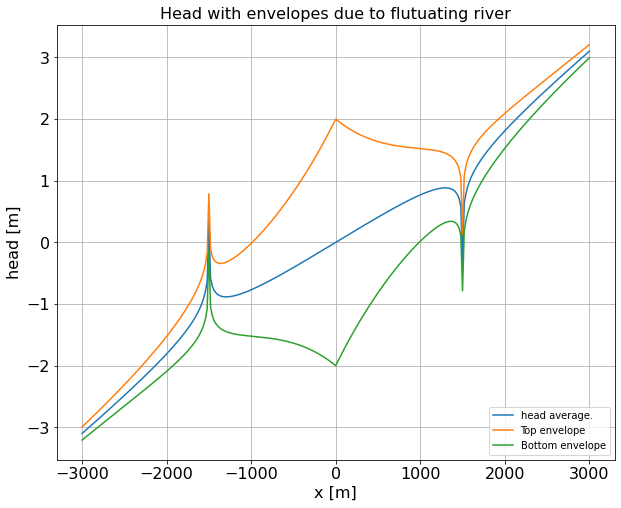

In [47]:

kD, Sy, q, Q, L, A = 900, 0.1, -1.0, 1200, 1500, 2.0

Xline = np.linspace(-3000, 3000, 301)

s = -q / kD * Xline

for k in wells:
    well = wells[k]
    r = np.abs(Xline - well['x'])
    r[r < well['r0']] = well['r0']

    s += -well['sign'] * Q / (2 * np.pi * kD) * np.log(r)

env = A * np.exp(-a * np.abs(Xline))

ax = newfig("Head with envelopes due to flutuating river", "x [m]", "head [m]")
ax.plot(Xline, s, label="head average.")
ax.plot(Xline, s + env, label="Top envelope")
ax.plot(Xline, s - env, label='Bottom envelope')

ax.legend(loc='lower right')

### 11 the delay of the wave at the point where the amplitude has declined by a factor of 20

$$ \omega t - ax = const \rightarrow  v_x = \frac{dx}{dt} = \omega /a \rightarrow t = L / v_x = L a / \omega$$


### Q10: By how much will the water table rise due to this sudden recharge is it is assumed that all this precipitation will add to the groundwater?

A uniform sudden shower of rain or rather recharge would thoretically lead to a sudden uniform rise of the head by $A = P / S_y$. Of course, reality is more complex, due to the difference between rain and infiltration into the subsurface, evaporation and delay in the unsaturated zone. These factors are neglected for now to allow the transient groundwater analys to be made.

### Q11:	Show the development of the water table over time (for a few times after the shower took place) by adding its effect to the steady-state situation (pumping station has been pumping continuously for at least 10 years? 

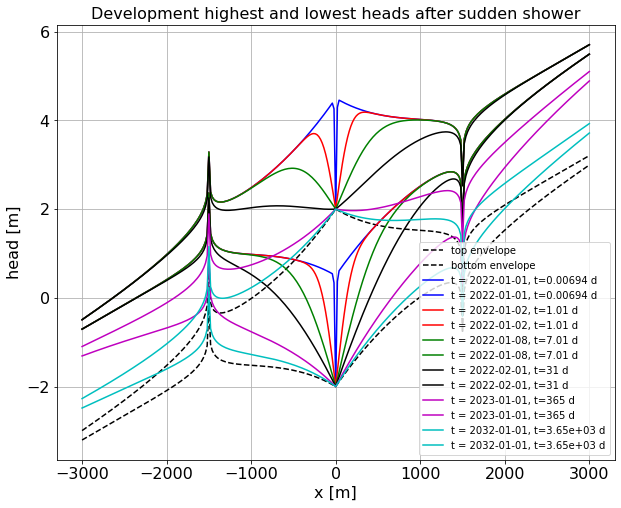

In [52]:
clrs = ['b', 'r', 'g', 'k', 'm', 'c']

kD, Sy, q, Q, L, A = 900, 0.1, -1.0, 1200, 1500, 2.0

Xline = np.linspace(-3000, 3000, 301)

P = 0.25  # Sudden recharge [m]
dHp = P / Sy # Sudden head change [m]

Tcycle = 365
omega = 2 * np.pi / Tcycle
a = np.sqrt(omega * Sy / (2 * kD))

env = A * np.exp(-a * np.abs(Xline))

ax = newfig("Development highest and lowest heads after sudden shower", "x [m]", "head [m]")

s = -q / kD * Xline # [m]

for k in wells:
    well = wells[k]
    r = np.abs(Xline - well['x'])
    r[r < well['r0']] = well['r0']

    s += -well['sign'] * Q / (2 * np.pi * kD) * np.log(r)
s1 = s + env
s2 = s - env  
ax.plot(Xline, s1, 'k--', label='top envelope')
ax.plot(Xline, s2, 'k--', label='bottom envelope')  

for clr, show_time in zip(clrs, show_times):
    t = (show_time - tstart) / np.timedelta64(1, 'D')
    u = np.abs(Xline) * np.sqrt(Sy / (4 * kD * t))
    s_top = s1 + dHp * (1 - erfc(u))
    s_bot = s2 + dHp * (1 - erfc(u))
    ax.plot(Xline, s_top, color=clr, label=f't = {show_time}, t={t:.3g} d')
    ax.plot(Xline, s_bot, color=clr, label=f't = {show_time}, t={t:.3g} d')
    
ax.legend(loc='lower right')

The curves show that the water levels sudden rise with a constant values relative to the dashed envelopes, which is where the head would vary due to a sine-like varying river level. Then the head gradually declines towards the dashed lines again. Further, the head at the river (x=0) nver changes due to recharge. It's fixed by the river.